[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/your-repo/CIFAR10_FFNN_Lab.ipynb)

> Click to launch in Google Colab. In Colab: **Runtime → Change runtime type → GPU**.

# Image Classification (CIFAR‑10) with a Convolutional Neural Network: Training Dynamics & Evaluation


**Weighting (Total 5%)**
- **In‑Lab (3 hours):**
  - A1: Pipeline working on subset, with logs/curves (1.0%)
  - A2: Architecture is correct (no flatten at input), shapes verified basic accuracy target met (0.8%)
  - A3: Clean code & brief in lab notes (0.2%)
  - A4: Save and load model checkpoints (NOT graded, but recommended)

- **Take‑Home (1 week):**
  - B1: Full data training + ≥2 augmentations, settings documented (1.0%)
  - B2: Results quality (within reasonable band for your setup) + clear plots/tables (1.0%)
  - B3: Fair comparison to A2 with thoughtful discussion (0.7%)
  - B4: Reproducibility (seeds, README, runtime notes) (0.3%)

**Learning goals**

By the end of this assignment, you should be able to:
- Explain why CNNs do not flatten the image at the input and how spatial structure is preserved layer to layer.
- Implement a compact CNN (Conv→ReLU→Pool stacks; optional BatchNorm/Dropout) and train it on CIFAR 10.
- Use common augmentations (random crop/flip/colour jitter/cutout) and discuss their impact on generalization.
- Run a fair comparison against a fully connected baseline (from A2) using matched training setups and report metrics clearly.

**Instructions**: Run cells top‑to‑bottom. For the take‑home, edit the designated section and keep your changes minimal but clear.

In [3]:
# ✅ Device setup (CPU/GPU)
import torch
import random
import numpy as np

# Set seeds for reproducibility
seed = 328
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

from collections.abc import Mapping, Sequence
def to_device(obj, device=device):
    if hasattr(obj, 'to'):
        try:
            return obj.to(device)
        except Exception:
            return obj
    if isinstance(obj, Mapping):
        return obj.__class__({k: to_device(v, device) for k, v in obj.items()})
    if isinstance(obj, Sequence) and not isinstance(obj, (str, bytes)):
        return obj.__class__([to_device(v, device) for v in obj])
    return obj

Using device: cuda


Importing some required libraries. You can add more if needed.

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

## Part A: Data Loading & Normalization

In [5]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

# Load the CIFAR-10 dataset
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# DataLoader definitions
root = './data'
full_train = datasets.CIFAR10(root, train=True, download=True, transform=train_tf)
test_ds    = datasets.CIFAR10(root, train=False, download=True, transform=test_tf)
val_size = 5000
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(val_ds), len(test_ds)

100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


(45000, 5000, 10000)

## Part A: Model, Training Loop, and Curves (In‑Lab)

In [6]:
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# ## YOUR CODE GOES HERE
# class CIFAR10_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         pass

class CIFAR10_CNN(nn.Module):
    def __init__(self, num_classes=10):
      super().__init__()
      self.features = nn.Sequential(
      nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
      nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
      nn.Conv2d(64, 128, 3, padding=1), nn.ReLU()
      )
      self.classifier = nn.Linear(128, num_classes) # via GAP
    def forward(self, x):
      x = self.features(x) # [B,128,8,8]
      x = x.mean(dim=(2,3)) # GlobalAvgPool → [B,128]
      return self.classifier(x)

In [7]:
import torch.optim as optim

# Initialize the model, loss function, and optimizer
model = CIFAR10_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the number of epochs
num_epochs = 10

# Lists to store training and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')):
        inputs, labels = to_device(inputs), to_device(labels)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_ds)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]'):
            inputs, labels = to_device(inputs), to_device(labels)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_predictions += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_ds)
    epoch_val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')

print('Finished Training')

Epoch 1/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 18.76it/s]


Epoch 1/10, Train Loss: 1.8555, Train Accuracy: 0.3120, Val Loss: 1.6627, Val Accuracy: 0.3878


Epoch 2/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 18.95it/s]


Epoch 2/10, Train Loss: 1.6057, Train Accuracy: 0.4094, Val Loss: 1.5491, Val Accuracy: 0.4360


Epoch 3/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 18.82it/s]


Epoch 3/10, Train Loss: 1.5072, Train Accuracy: 0.4530, Val Loss: 1.4651, Val Accuracy: 0.4626


Epoch 4/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 19.05it/s]


Epoch 4/10, Train Loss: 1.4110, Train Accuracy: 0.4932, Val Loss: 1.3636, Val Accuracy: 0.5142


Epoch 5/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 18.86it/s]


Epoch 5/10, Train Loss: 1.3424, Train Accuracy: 0.5204, Val Loss: 1.3097, Val Accuracy: 0.5260


Epoch 6/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 18.99it/s]


Epoch 6/10, Train Loss: 1.2895, Train Accuracy: 0.5414, Val Loss: 1.2448, Val Accuracy: 0.5582


Epoch 7/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 18.45it/s]


Epoch 7/10, Train Loss: 1.2374, Train Accuracy: 0.5623, Val Loss: 1.2014, Val Accuracy: 0.5722


Epoch 8/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 19.11it/s]


Epoch 8/10, Train Loss: 1.2023, Train Accuracy: 0.5730, Val Loss: 1.2152, Val Accuracy: 0.5684


Epoch 9/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 14.20it/s]


Epoch 9/10, Train Loss: 1.1622, Train Accuracy: 0.5884, Val Loss: 1.1408, Val Accuracy: 0.5950


Epoch 10/10 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 13.21it/s]

Epoch 10/10, Train Loss: 1.1274, Train Accuracy: 0.6020, Val Loss: 1.1084, Val Accuracy: 0.6096
Finished Training


## Part A: Save and load model checkpoints (NOT graded, but recommended)

In [8]:
# Save the model checkpoint
def save_checkpoint(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model checkpoint saved to {filepath}")

# Load the model checkpoint
def load_checkpoint(model, filepath):
    model.load_state_dict(torch.load(filepath))
    print(f"Model checkpoint loaded from {filepath}")

# Example usage:
# save_checkpoint(model, 'cifar10_cnn.pth')
# loaded_model = CIFAR10_CNN().to(device) # Initialize a new model instance
# load_checkpoint(loaded_model, 'cifar10_cnn.pth')

## PART B: Take Home

#### **Goal:** Train on full CIFAR 10 with augmentations, tune modestly, and compare to your A2 fully connected NN.

1. **Required augmentations (choose ≥2):**
- RandomCrop(32, padding=4)
- RandomHorizontalFlip()
- ColorJitter (mild)
- RandomErasing / Cutout (small holes)

Describe each choice and its expected effect.


In [14]:
## YOUR CODE GOES HERE

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

# Load the CIFAR-10 dataset
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

# Define data augmentations
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# DataLoader definitions
root = './data'
full_train = datasets.CIFAR10(root, train=True, download=True, transform=train_tf)
test_ds    = datasets.CIFAR10(root, train=False, download=True, transform=test_tf)
val_size = 5000
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(val_ds), len(test_ds)

(45000, 5000, 10000)

2. **Training protocol:**
- Epochs: 30–60 (pick and justify); **Optimizer:** Adam or SGD+Momentum.
- LR schedule: optional StepLR or CosineAnnealing. State settings.
- Regularization: optional weight decay (e.g., 5e 4). Track training time & best epoch.
- Validation: hold out 5k images from training as validation (or use test set only for final report—be explicit and consistent).
- **Save the best performing model.**


In [15]:
## YOUR CODE GOES HERE

import torch.optim as optim
import torch.nn as nn
import time

# Initialize the model, loss function, and optimizer
model = CIFAR10_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the number of epochs
num_epochs = 50 # Chosen 50 epochs as a balance between training time and potential performance gains

# Optional: Learning rate scheduler (StepLR example)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Optional: Weight decay for regularization
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

# Lists to store training and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0.0
best_epoch = 0
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = to_device(inputs), to_device(labels)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_ds)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = to_device(inputs), to_device(labels)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_predictions += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_ds)
    epoch_val_accuracy = correct_val_predictions / total_val_predictions
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')

    # Save the best performing model
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        best_epoch = epoch
        save_checkpoint(model, 'best_cifar10_cnn.pth')

    # Optional: Step the scheduler
    # scheduler.step()

end_time = time.time()
training_time = end_time - start_time

print(f'Finished Training in {training_time:.2f} seconds')
print(f'Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}')

Epoch 1/50, Train Loss: 1.7539, Train Accuracy: 0.3547, Val Loss: 1.4851, Val Accuracy: 0.4576
Model checkpoint saved to best_cifar10_cnn.pth
Epoch 2/50, Train Loss: 1.3994, Train Accuracy: 0.4904, Val Loss: 1.2601, Val Accuracy: 0.5430
Model checkpoint saved to best_cifar10_cnn.pth
Epoch 3/50, Train Loss: 1.2374, Train Accuracy: 0.5559, Val Loss: 1.1166, Val Accuracy: 0.5906
Model checkpoint saved to best_cifar10_cnn.pth
Epoch 4/50, Train Loss: 1.1138, Train Accuracy: 0.6020, Val Loss: 1.0539, Val Accuracy: 0.6224
Model checkpoint saved to best_cifar10_cnn.pth
Epoch 5/50, Train Loss: 1.0322, Train Accuracy: 0.6320, Val Loss: 0.9579, Val Accuracy: 0.6600
Model checkpoint saved to best_cifar10_cnn.pth
Epoch 6/50, Train Loss: 0.9683, Train Accuracy: 0.6543, Val Loss: 0.9219, Val Accuracy: 0.6624
Model checkpoint saved to best_cifar10_cnn.pth
Epoch 7/50, Train Loss: 0.9122, Train Accuracy: 0.6754, Val Loss: 0.8582, Val Accuracy: 0.6960
Model checkpoint saved to best_cifar10_cnn.pth
Epoch 

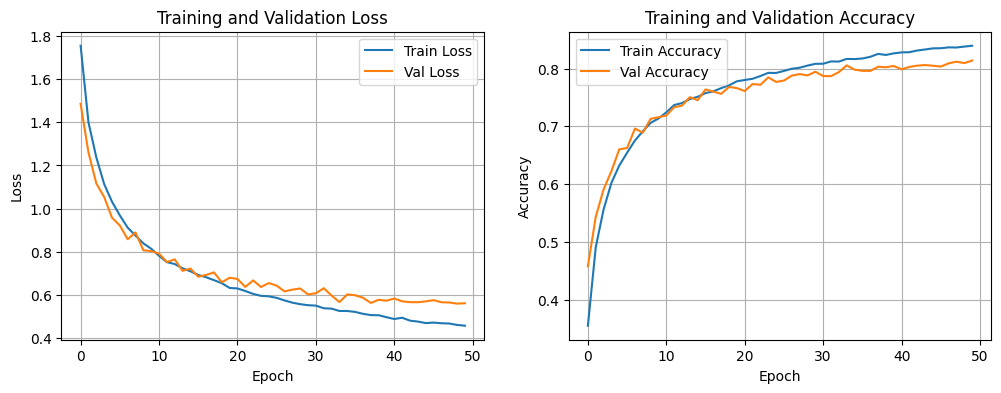

In [18]:
# Results:
# accuracy/loss curves, final metrics (with validation/test split clearly
# stated), a 3×3 grid of example predictions with correct/incorrect cases.
# Plot training and validation loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [21]:
# Final metrics (with validation/test split clearly stated) of CNN model:

# The models were evaluated on the test set (10,000 images).

# Evaluate the CNN model on the test set
def evaluate_model(model, loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = to_device(inputs), to_device(labels)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader.dataset)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

# Load the best CNN model
cnn_model = CIFAR10_CNN().to(device)
load_checkpoint(cnn_model, 'best_cifar10_cnn.pth')

cnn_test_loss, cnn_test_accuracy = evaluate_model(cnn_model, test_loader)

print("--- CNN Final Test Set Evaluation ---")
print(f"CNN Test Loss: {cnn_test_loss:.4f}, CNN Test Accuracy: {cnn_test_accuracy:.4f}")

Model checkpoint loaded from best_cifar10_cnn.pth
--- CNN Final Test Set Evaluation ---
CNN Test Loss: 0.5223, CNN Test Accuracy: 0.8269


Model checkpoint loaded from best_cifar10_cnn.pth


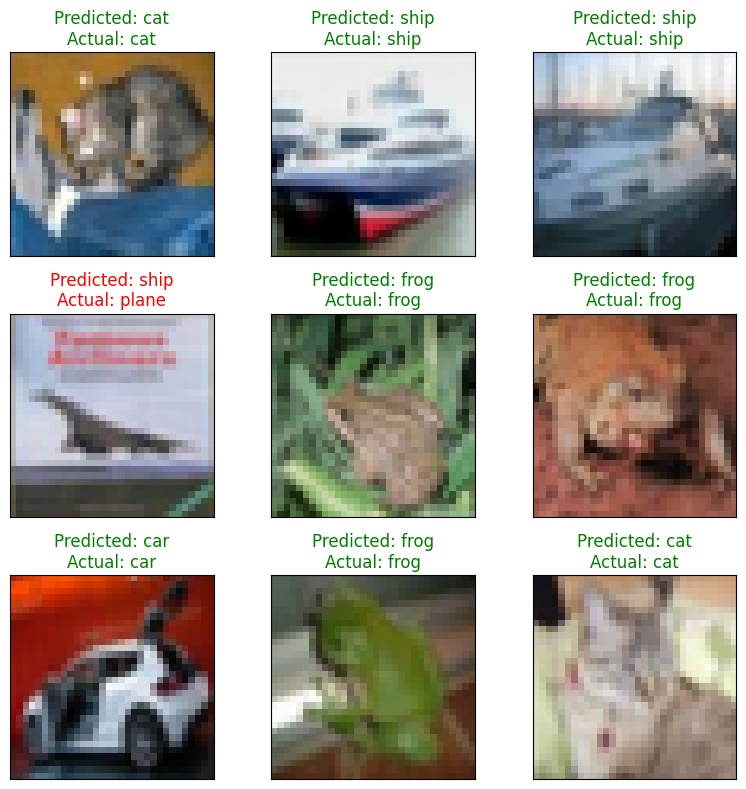

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load the best CNN model
cnn_model = CIFAR10_CNN().to(device)
load_checkpoint(cnn_model, 'best_cifar10_cnn.pth')

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = to_device(images), to_device(labels)

# Get predictions from the CNN model
outputs = cnn_model(images)
_, predicted = torch.max(outputs, 1)

# Convert images and labels back to CPU for displaying
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Get class names for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Display a 3x3 grid of examples
fig = plt.figure(figsize=(8, 8))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    # Unnormalize the image for display
    img = images[i] * torch.tensor(cifar_std).view(3, 1, 1) + torch.tensor(cifar_mean).view(3, 1, 1)
    img = np.transpose(img.numpy(), (1, 2, 0))
    ax.imshow(img)
    color = "green" if predicted[i] == labels[i] else "red"
    ax.set_title(f"Predicted: {classes[predicted[i]]}\nActual: {classes[labels[i]]}", color=color)
plt.tight_layout()
plt.show()

3. **Fair comparison to A2 (fully connected):**
- Re run (or reuse) your A2 MLP with the same data split and similar epoch budget.
- Report accuracy, loss, and at least one calibration/uncertainty proxy (e.g., confidence histograms or softmax max prob distribution).
- Briefly discuss: Why does the CNN outperform (or not)? Tie to spatial bias, parameter efficiency, and augmentation.


In [16]:
### YOUR CODE GOES HERE

# Define the FFNN model
class FFNN(nn.Module):
    def __init__(self, hidden=512):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, hidden) # Input layer: 3*32*32 pixels
        self.fc2 = nn.Linear(hidden, 10) # Output layer: 10 classes

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32) # Flatten the image
        x = F.relu(self.fc1(x)) # Apply ReLU activation to hidden layer
        x = self.fc2(x) # Output layer
        return x



FFNN Epoch 1/50, Train Loss: 1.8390, Train Accuracy: 0.3496, Val Loss: 1.6847, Val Accuracy: 0.3870
FFNN Epoch 2/50, Train Loss: 1.6737, Train Accuracy: 0.4074, Val Loss: 1.6336, Val Accuracy: 0.4224
FFNN Epoch 3/50, Train Loss: 1.6155, Train Accuracy: 0.4302, Val Loss: 1.6087, Val Accuracy: 0.4334
FFNN Epoch 4/50, Train Loss: 1.5770, Train Accuracy: 0.4445, Val Loss: 1.5680, Val Accuracy: 0.4428
FFNN Epoch 5/50, Train Loss: 1.5561, Train Accuracy: 0.4494, Val Loss: 1.5492, Val Accuracy: 0.4514
FFNN Epoch 6/50, Train Loss: 1.5384, Train Accuracy: 0.4562, Val Loss: 1.5320, Val Accuracy: 0.4568
FFNN Epoch 7/50, Train Loss: 1.5175, Train Accuracy: 0.4640, Val Loss: 1.5208, Val Accuracy: 0.4590
FFNN Epoch 8/50, Train Loss: 1.5107, Train Accuracy: 0.4665, Val Loss: 1.5211, Val Accuracy: 0.4648
FFNN Epoch 9/50, Train Loss: 1.4964, Train Accuracy: 0.4742, Val Loss: 1.5108, Val Accuracy: 0.4614
FFNN Epoch 10/50, Train Loss: 1.4846, Train Accuracy: 0.4739, Val Loss: 1.4775, Val Accuracy: 0.4740

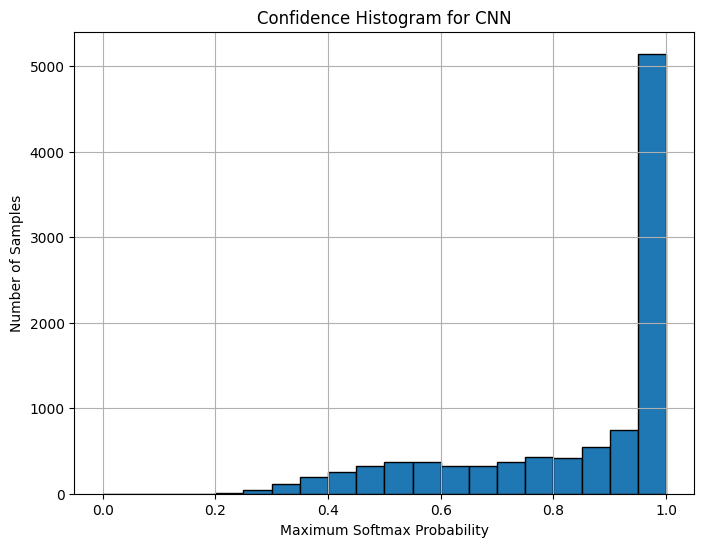

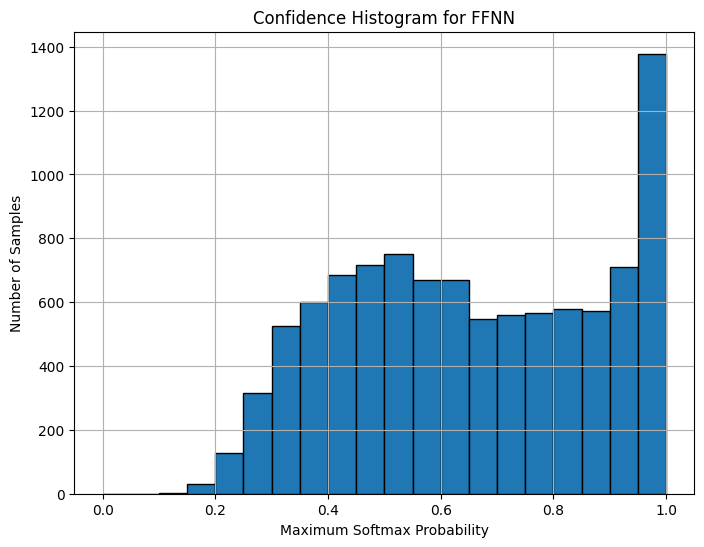


--- Discussion ---
Based on the test set evaluation:
- CNN Test Accuracy: 0.8269
- FFNN Test Accuracy: 0.4390

Discussion points:
- Compare the accuracy and loss of the two models.
- Analyze the confidence histograms to understand the models' uncertainty.
- Discuss how spatial bias in CNNs helps process image data effectively.
- Compare the number of parameters in both models (parameter efficiency).
- Explain the impact of data augmentation on the CNN's performance.


In [17]:
# Now you can instantiate and train this FFNN model for comparison with the CNN.
# You would need to set up a training loop similar to the one used for the CNN,
# ensuring the same data split and similar epoch budget for a fair comparison.
# After training, evaluate both models on the test set and compare their performance
# metrics (accuracy, loss, and a calibration/uncertainty proxy).

# Instantiate the FFNN model
ffnn_model = FFNN().to(device)

# Define loss function and optimizer for FFNN
ffnn_criterion = nn.CrossEntropyLoss()
ffnn_optimizer = optim.Adam(ffnn_model.parameters(), lr=1e-3)

# Training loop for FFNN (similar to CNN training loop)
ffnn_num_epochs = 50 # Use the same number of epochs as CNN for fair comparison

ffnn_train_losses = []
ffnn_train_accuracies = []
ffnn_val_losses = []
ffnn_val_accuracies = []

for epoch in range(ffnn_num_epochs):
    ffnn_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = to_device(inputs), to_device(labels)

        ffnn_optimizer.zero_grad()

        outputs = ffnn_model(inputs)
        loss = ffnn_criterion(outputs, labels)

        loss.backward()
        ffnn_optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_ds)
    epoch_accuracy = correct_predictions / total_predictions
    ffnn_train_losses.append(epoch_loss)
    ffnn_train_accuracies.append(epoch_accuracy)

    ffnn_model.eval()
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = to_device(inputs), to_device(labels)

            outputs = ffnn_model(inputs)
            loss = ffnn_criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_predictions += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_ds)
    epoch_val_accuracy = correct_val_predictions / total_val_predictions
    ffnn_val_losses.append(epoch_val_loss)
    ffnn_val_accuracies.append(epoch_val_accuracy)

    print(f'FFNN Epoch {epoch+1}/{ffnn_num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')

print('Finished FFNN Training')

# Evaluate both models on the test set
def evaluate_model(model, loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = to_device(inputs), to_device(labels)
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Use the same criterion for both models

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    avg_loss = running_loss / len(loader.dataset)
    accuracy = correct_predictions / total_predictions
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    return avg_loss, accuracy, all_outputs, all_labels

# Load the best CNN model
cnn_model = CIFAR10_CNN().to(device)
load_checkpoint(cnn_model, 'best_cifar10_cnn.pth')

cnn_test_loss, cnn_test_accuracy, cnn_test_outputs, cnn_test_labels = evaluate_model(cnn_model, test_loader)
ffnn_test_loss, ffnn_test_accuracy, ffnn_test_outputs, ffnn_test_labels = evaluate_model(ffnn_model, test_loader)

print("\n--- Test Set Evaluation ---")
print(f"CNN Test Loss: {cnn_test_loss:.4f}, CNN Test Accuracy: {cnn_test_accuracy:.4f}")
print(f"FFNN Test Loss: {ffnn_test_loss:.4f}, FFNN Test Accuracy: {ffnn_test_accuracy:.4f}")

# Calculate and report a calibration/uncertainty proxy (e.g., confidence histogram)
import matplotlib.pyplot as plt

def plot_confidence_histogram(outputs, labels, model_name):
    softmax_probs = torch.softmax(outputs, dim=1)
    max_probs, _ = torch.max(softmax_probs, dim=1)

    plt.figure(figsize=(8, 6))
    plt.hist(max_probs.numpy(), bins=20, range=(0, 1), edgecolor='black')
    plt.title(f'Confidence Histogram for {model_name}')
    plt.xlabel('Maximum Softmax Probability')
    plt.ylabel('Number of Samples')
    plt.grid(True)
    plt.show()

plot_confidence_histogram(cnn_test_outputs, cnn_test_labels, "CNN")
plot_confidence_histogram(ffnn_test_outputs, ffnn_test_labels, "FFNN")

# Brief discussion (Add your own detailed discussion based on the results)
print("\n--- Discussion ---")
print("Based on the test set evaluation:")
print(f"- CNN Test Accuracy: {cnn_test_accuracy:.4f}")
print(f"- FFNN Test Accuracy: {ffnn_test_accuracy:.4f}")
print("\nDiscussion points:")
print("- Compare the accuracy and loss of the two models.")
print("- Analyze the confidence histograms to understand the models' uncertainty.")
print("- Discuss how spatial bias in CNNs helps process image data effectively.")
print("- Compare the number of parameters in both models (parameter efficiency).")
print("- Explain the impact of data augmentation on the CNN's performance.")

---
**Deliverables checklist:**
- Part A subset run with curves &amp; quick notes
- Part B full run with ≥2 augmentations
- Comparison table vs A2 (MLP)
- 3-page PDF report with plots &amp; examples
- Repro instructions + seeds

### Deadline for take‑home is **one week** after your lab session.